# Table of Contents
1. [Introduction and Motivations](#Introduction-and-Motivations)
2. [Project Overview](#Project-Overview)
3. [Setup](#Setup)
4. [Data Modeling & Databases](#Data-Modeling-&-Databases)
5. [Data Collection](#Data-Collection)
6. [Data Cleaning & Entity Extraction](#Data-Cleaning-&-Entity-Extraction)
7. [Data Visualization](#Data-Visualization)
8. [Future Work](#Future-Work)
9. [Citations](#Citations)


# Introduction and Motivations

## Why study Hip hop?
Over the past 50 years, Hip hop culture has grown from an underground subculture into a global phenomenon. However, at it's core, Hip hop culture is first and foremost black culture and youth culture. Although 1973 is treated as the "official" birth year of Hip hop culture, it's roots extend much further back into the social movements of the 50's and 60's and cultural practices stemming from the African diaspora. Through the myriad of artistic disciplines under it's umbrella, it's provided a platform for disenfranchised youth to express themselves and give themselves a voice in the face of oppression. As a result, studying Hip hop culture is critical to understanding the lives and experiences of the marginalized communities that pioneered it and continue to champion it to this day.

## Key Challenges
There are several key challenges when it comes to studying Hip hop culture:
* Oral history - A lot of Hip hop's very early history has not been formally recorded or documented. For many years, a lot of this history was simply passed down orally from generation to generation. With each retelling, there's always a risk of key details being changed, exaggerated, or simply lost to time.
* Loss of materials and artifacts - Hip hop was birthed in the 1970's. A lot of the media formats that existed at the time were not developed with long term data storage in mind. As a result, many artifacts from the early days of Hip hop culture are at risk of degradation and data loss if not preserved.
* Misrepresentation - Hip hop culture has a long history of being exploited for financial gain by people outside of its communities of practice. As a result, parts of the culture are sometimes misrepresented or "watered down" to make them more palatable to mainstream audiences. One popular example is the misrepresentation of breaking (aka breakdance) as "dance fighting".

## Why study Hip hop in Boston?
Boston is often overlooked as a "Hip hop" city. This may be due to several factors including the city's already strong reputation as a "Rock N' Roll city" and discriminatory booking practices, on the part of local venues, that have prevented local Hip hop acts from performing in the city. However, Boston has a strong Hip hop legacy and has made many rich contributions to the culture. Over the years, it has produced:
* internationally renowned Hip hop acts such as Gang Starr, Edo G, and Czarface.
* a slew of world-class breakers (El Nino, Omen, Bebo, etc.) and some of the longest running breaking crews in the USA.
* the longest running Hip hop magazine (The Source) which was first published out of a Harvard dorm room.

In short, it is impossible to tell the story of Hip hop culture without mentioning the contributions of communities in and around Boston such as Roxbury, Dorchester, Lynn, and Cambridge. As a result, studying and preserving Boston's homegrown Hip hop culture also means preserving the history of its local communities, amplifying underrepresented voices, and acknowledging the contributions of marginalized communities to a global movement.

This project was conceived as one potential effort to address the aforementioned challenges to studying Hip hop culture and to shed greater light on the connections between communities in this city and Hip hop culture. 

# Project Overview

Over the past decade, video sharing and social media platforms like YouTube have made it substantially easier to document and disseminate information about Hip hop culture. There are already a plethora of YouTube channels and podcasts devoted to interviewing Hip hop pioneers and giving them a platform to tell their stories. 

However, as time goes by these valuable sources of knowledge/history are becoming harder to find as search algorithms prioritize more recently published videos and more popular content. In addition, these videos can get taken down at any time if the video sharing platform deems them to be in violation of copyright laws or community guidelines.

Accordingly, the goals of this project are to:
* develop a data pipeline to try and preserve the knowledge and stories contained within these video interviews
* create a visualization tool to explore and establish the connections between various local Hip hop cultural icons and the communities that created them.

The image below depicts a rough overview of how the pipeline should run and how the project should work.

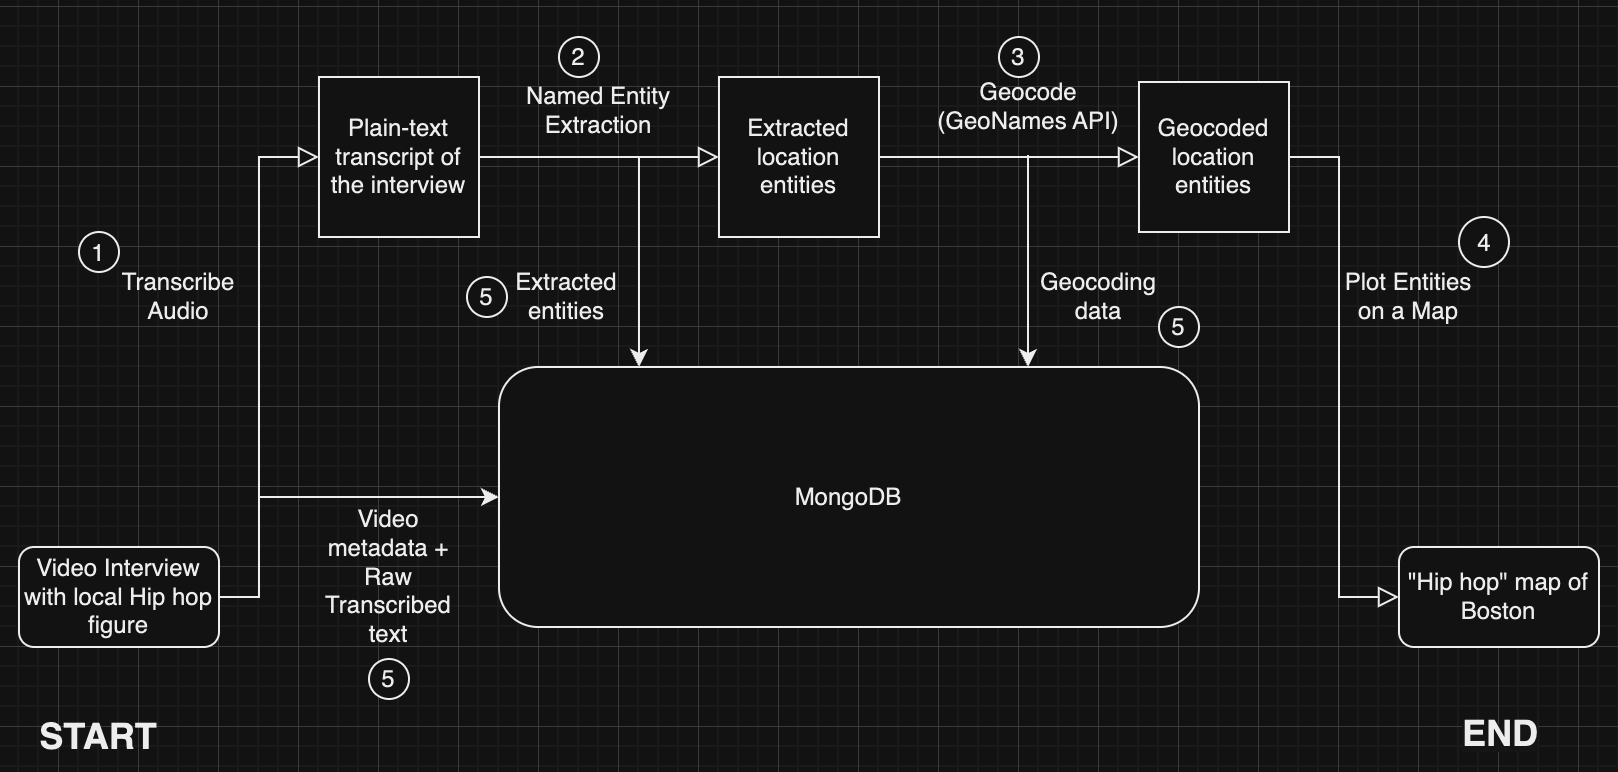

1. Audio is extracted from video interviews and transcribed into plain text.
2. Plain text transcripts are processed using NER (Named Entity Recognition) to identify the names of physical locations around the Greater Boston area in each interview transcript.
3. Extracted location entities are geocoded via the GeoNames API.
4. Geocoded entity data is passed to a mapping library to generate an interactive visualization of all the places around Boston that have ties to Hip hop culture so that viewers can see the direct impact various neighborhoods and communities in the greater Boston area have had on Hip hop culture.
5. Various data and metadata is pushed into a MongoDB database at different points of the pipeline.

# Setup

This project was developed using Python 3.10.4.

The code snippet below can be run on the command line and used to setup a virtual environment to hold all the libraries that are required to run the code in this project. 

```bash
python -m venv hip_hop_map_project
```

After the virtual environment is created, run the following three lines of code to start the virtual environment and install all the required libraries for this project.

```bash
source hip_hop_map_project/bin/activate
pip install -r requirements.txt
python -m spacy download en_core_web_trf
```

# Data Modeling & Databases

## Data Models
These data models were developed based on the proposed data pipeline outlined in the Project Overview section. It should be noted that Media and Transcript are separate documents linked by a foreign key but Entity is an embedded document in Transcript. The models were setup this way because a single piece of media could eventually have several different transcripts (generated by different tools) but most of the metadata contained in the media document is irrelevant to the code that will operate on the transcript documents. 

On the other hand, the entity documents are closely related in function to the transcripts so it seemed appropriate to embed them into the transcript document rather than having them exist as a separate document.

### Media 
| Field Name | Description |
| ---------- | ----------- |
| _id        | An auto-generated unique id field. |
| platform   | The website or platform that this piece of media was found on. (Ex. YouTube) |
| url        | The URL for this piece of media. |
| title      | The title of this piece of media. |
| type       | The type of this media (Ex. audio, video, image, etc.) |
| description| A brief description of the media. |

### Transcript
| Field Name | Description |
| ---------- | ----------- |
| _id        | An auto-generated unique id field. |
| media_id   | Foreign key to the _id field on media objects. Media has a one-to-many relationship with Transcript. |
| cleaned    | A boolean value. Has this transcript been cleaned or not? |
| date_generated | The date that this transcript was generated on. |
| generated_with | The algorithm or tool used to generate the transcript. |
| transcript_raw_text | The raw plain text transcript of the media's audio. |
| named_entities | A list of embedded named entities. The data model for an individual entity is in the table below. |

### Entity
| Field Name | Description |
| ---------- | ----------- |
| entity_text | The text of the entity. |
| entity_label | The label that was given to the entity by the software tool or program that extracted it. |
| date_generated | The date the entity was generated. |
| tool_used | The tool or algorithm that was used to perform NER or some other form of NLP to extract the entity. |
| address | Address assigned to the entity by a geocoding service. |
| lat | Latitude assigned to the entity by a geocoding service. |
| lng | Longitude assigned to the entity by a geocoding service. |
| geonames_id | GeoNames ID assigned to the entity by a geocoding service. |

## Database
After drawing up the data models, I thought a NoSQL database would work well for this project. As a result, I decided to use MongoDB for this project. In order to run this notebook, [make sure you have MongoDB set up on your local machine](https://www.mongodb.com/docs/manual/installation/). 

The code snippet below takes a csv file containing metadata on a local Boston Hip hop podcast series (see the Data Collection section for more information) as input, creates a MongoDB database, and loads the data into the database.

In [ ]:
import pymongo
import csv

def load_interview_data(input_csv_file, collection, description):
    """Takes a csv file of video interviews as input and uploads it into MongoDB collection."""
    # open input csv and read in data
    with open(input_csv_file, "r", encoding="utf-8-sig") as csv_file:
        csv_reader = csv.DictReader(csv_file)
        videos = []
        # read in video metadata from csv
        for row in csv_reader:
            video = {
                "title": row.get("Title"),
                "type": "video",
                "url": row.get("Url"),
                "platform": row.get("Platform"),
                "description": description
            }
            videos.append(video)
            print(f"Successfully added media info for {video.get('title')} to database.")
        # bulk insert video metadata into the db
        result = collection.insert_many(videos)
            
if __name__ == "__main__":
    # Connect to MongoDB Client
    client = pymongo.MongoClient("localhost",27017)
    db = client["boston-hip-hop-interviews"]
    
    # Get media table
    media_collection = db["media"]

    input_csv_file = "interviews.csv"
    result = load_interview_data(input_csv_file, media_collection, "Video interview from the Boston Hip hop podcast series 'Tha Show 617'.")

# Data Collection

I identified a local Hip hop podcast called "Tha Show 617" that ran from 2008 to approximately 2014 as a potential first dataset for developing this data pipeline. The podcast spanned 24 episodes and featured interviews with prominent local Hip hop artists including emcees, DJ's, and breakers. 

This podcast was particularly interesting because it existed both as a [video series on YouTube](https://www.youtube.com/@THASHOW617/videos) as well as a [purely audio podcast on podomatic.com](https://www.podomatic.com/podcasts/thashow617). Due to video length upload limits at the time, interviews that were longer than 10 minutes would be split up into multi-part segements in the YouTube series but were uploaded as a single audio file on podomatic.com. Each podcast episode would run for approximately 20min - 40min and would begin with a short intro sequence and end with a short video montage of the artist performing their art at local events.

As a result of this interesting dual format, I experimented with several different methods for transcribing the podcast audio and generating the transcript dataset.

## Key challenges with audio transcription
A variety of speech recognition programs exist for transcribing audio files to a plain text format. However, most of these speech-to-text algorithms are plagued by similar issues that cause inaccuracies in audio transcription. These inaccuracies are particularly abundant in audio where the speaker has an accent, uses the English pronounciation/representation of words or phrases from another language, uses modern slang or abbreviations, or is speaking about a niche topic (Ex. Hip hop culture) which may not be very well represented in the language models that the speech-to-text algorithms rely on. 

For example, in [one interview](https://youtu.be/_NXu_KZHVdk?si=XV8C365u3j7_izCU&t=210) Brian Lim, a local Hip hop figure, speaks about his experiences with his first breaking crew "Bai Cha" breakers. Bai Cha is the romanization of the Khmer phrase បាយ​ឆា which literally translates to "Fried Rice" in English. However, a typical speech-to-text algorithm has no way of knowing that this particular word is the romanization of a Khmer phrase and will instead attempt to look for the closest English equivalent. As a result, this term is mistranscribed as "buy a child", "baja", and "bachata" at different points in the interview by YouTube's speech-to-text algorithms.

Another key issue with speech-to-text algorithms is that many of them are compute intensive. In order to achieve high accuracy, many of these algorithms rely on large statistical models to transcribe audio. As a result, there's typically a speed-to-accuracy tradeoff with many of these algorithms where the most accurate audio transcription models typically require a significant amount of compute and long runtimes compared to the more lightweight models. Additionally, some of the most popular speech-to-text algorithms (Ex. Google) are also only available via API calls and have rate limits on how much audio can be transcribed in the "free" tier of usage. Furthermore, speaker diarization--the ability to determine when different speakers are talking in audio clips--is also not typically provided by default by these algorithms. Finally, most audio transcription services will not add punctuation to their transcripts which reduces their human readability and makes them difficult to manually clean.

## Method 1 - Microsoft OneNote + manual data curation
During my initial research into audio transcription, one of the most popular suggestions was simply to play whatever audio I was interested in transcribing on my computer's speakers, use the dictate feature in Microsoft OneNote to transcribe the audio as it played, and then to manually fix any transcription issues.

This method turned out to be surprisingly robust. The Microsoft OneNote transcription feature was not rate limited and was fairly accurate at transcribing names and places. In addition, the Microsoft 365 OneNote services offered 300 minutes per month of free speaker diarization.

However, one key limitation of this approach was that it was difficult to scale and difficult to perform programatically. Because the OneNote service requires the audio to be playing on the computer's speakers, transcribing a given video will take approximately the same amount of time as the video's run time. As a result, transcribing 24 episodes of a podcast series that's approximately 20min - 40min per episode would take between 8hrs - 16hrs (480min - 960min). The transcription service also stops recording and transcribing as soon as the user navigates to a different window meaning that I would essentially be unable to use my machine for anything else while the audio is being transcribed.

## Method 2 - Transcribing podcast audio
Each podcast episode on podomatic.com was available for download. As a result, I thought of simply downloading all the podcast episodes from podomatic and using a speech-to-text library to transcribe them.

This approach carried several advantages including not having to deal with the multi-part video interviews on YouTube and being able to use different speech-to-text algorithms that may perform better than YouTube's internal speech-to-text algorithm. I surveyed several possible speech-to-text libraries summarized in the table below.

| Library                 | Advantages             | Disadvantages               |
| ----------------------- | ---------------------- | --------------------------- |
| [PocketSphinx](https://github.com/cmusphinx/pocketsphinx) | Well established, open source library for speech recognition.                    | No longer being actively developed and far from state of the art by their own admittance.                             |
| [Google Cloud Speech API](https://cloud.google.com/speech-to-text) | Well established, and actively maintained. Because it's by API call there's no need to download large models onto my personal machine. Can leverage cloud compute. | Rate limited. Free tier can only process very small clips of audio. |
| [Open AI Whisper](https://github.com/openai/whisper)         | Leverage's OpenAI's powerful LLM models to perform speech recognition. Multiple model sizes so that users can choose the accuracy-speed tradeoff that works best for their use case. Can be run off-line. | Even the fastest model is still relatively slow and can take 10+ minutes to process an episode. |

Out of the tools I evaluated, OpenAI's Whisper seemed to be the most promising and I was able to test it out by running the code below on the command line. 
```bash
yt-dlp -f best "https://www.youtube.com/watch?v=_NXu_KZHVdk"
whisper "Tha Show 617 - Episode 22 -part1 - B-Boy Brian from Problemz Kru [_NXu_KZHVdk].mp4" --model tiny
```
However, due to time constraints I ultimately chose to use Method #3 (described below) to generate the transcript dataset.

## Method 3 - Retrieving auto-generated captions from YouTube videos
Many YouTube videos contain captions that were auto-generated by YouTube's internal speech-to-text algorithms. These caption tracks have improved in quality over time but are plagued by many of the issues and inaccuracies I mentioned in the "key challenges with audio transcription" section. Additionally, for this dataset the auto-generated captions are not available for all podcast episodes and certain episodes appeared to have audio issues (Ex. audio was muted, potentially because of the use of copyrighed music as background music).

In spite of these challenges, I thought this approach still had several advantages over other approaches. Namely, the captions were already generated and simply had to be retrieved. As a result, I wouldn't have to spend significant computational resources and time waiting for a speech-to-text algorithm to process all the podcast audio. I ultimately chose to use this approach due to time constraints.

I experimented with several different libraries for retrieving auto-generated captions from YouTube and detailed my experiences with them in the table below. 

| Library                 | Advantages             | Disadvantages               |
| ----------------------- | ---------------------- | --------------------------- |
| [YouTubeDL](https://github.com/ytdl-org/youtube-dl)           | Open-source library for downloading videos or parts of a video from different video sharing platforms. Updated pretty regularly to account for regular updates and changes in the YouTube API. Recently modified their codebase to make sure they're compliant with copyright laws after a DMCA takedown attempt and got their repository re-instated by Github.                      | Current stable release available via pip appears to be broken due to a change in YouTube API. Working version can still be git pulled from Github.                            |
| [yt-dlp](https://github.com/yt-dlp/yt-dlp) | A fork of YouTubeDL. The latest stable release avaible via pip works. Able to successfully pull the auto-generated caption tracks from YouTube.                      | Auto-generated caption tracks pulled by yt-dlp appear to have an odd quirk where every line of audio is repeated 2-3 times. Converting these caption tracks to a plain text format results in a plain text file with many duplicate lines. Current fix is just to use a separate cleaning script to remove potential duplicates.                            |
| [pytube](https://github.com/pytube/pytube)                | Simple lightweight library for downloading captions from YouTube.                       | Caption download feature for auto-generated captions appears to be broken (tested it out with a video that had a caption track).                           |
| [youtube-transcript-api](https://github.com/jdepoix/youtube-transcript-api)         | Simple library that just does one thing very well (download caption tracks). Contains built in formatter for converting the caption track format to JSON or plain text.                        | Not much additional functionality outside of downloading captions.                            |

Ultimately, I chose to use the youtube-transcript-api library for its simplicity and built-in ability to reformat caption tracks as plain text. The script below retrieves all YouTube media objects from the DB and attempts to download their caption tracks.

In [ ]:
import os
import pymongo
import datetime

from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled
from youtube_transcript_api.formatters import TextFormatter

def fetch_and_format_transcript(transcript_api, formatter, video_id):
    """Tiny function for getting caption tracks from YouTube videos then formatting them as Plain Text."""
    transcript = transcript_api.get_transcript(video_id)
    return formatter.format_transcript(transcript)

if __name__ == "__main__":
    # Connect to MongoDB Client
    client = pymongo.MongoClient("localhost", 27017)
    db = client["boston-hip-hop-interviews"]
    
    # Get relevant collections
    media_collection = db["media"]
    transcript_collection = db["transcript"]
    
    # instantiate Youtube transcript API object and formatter
    transcript_api = YouTubeTranscriptApi()
    formatter = TextFormatter()

    # iterate over all the YouTube videos in the db and download their caption tracks
    transcript_list = []
    for video in media_collection.find({"platform": "YouTube"}):
        video_id = video.get("url").split("watch?v=")[1]
        try:
            # attempt to fetch the auto-generated captions from YouTube
            transcript = fetch_and_format_transcript(transcript_api, formatter, video_id)
            transcript_list.append({
                "media_id": video.get("_id"),
                "date_generated": datetime.datetime.now(),
                "generated_with": "YouTube auto-captions",
                "cleaned": False,
                "transcript_raw_text": transcript
            })
            print(f"Successfully fetched transcript for {video.get('title')}")
        except TranscriptsDisabled:
            print(f"Error: {video.get('title')} has no available captions.")
        except Exception as e:    
            print(e)

    result = transcript_collection.insert_many(transcript_list)
    print(result)

# Data Cleaning & Entity Extraction

After downloading the caption tracks, the next step was to extract the names of locations and places from the raw text. The standard way to programmatically perform this extraction is via the NLP technique known as Named Entity Recognition or NER for short. This technique utilizes statistical models to attempt to label each "token" (essentially each word) in a piece of text with a label based on it's position and surrounding context. 

Many different libraries exist for performing NER. Before settling on the spacy library, I tested out other libraries including [geograpy3](https://github.com/somnathrakshit/geograpy3) and the open source [bert-base-NER](https://huggingface.co/dslim/bert-base-NER) library. Unfortunately due to time constraints I was not able to run a benchmarking test on the libraries side-by-side. I chose spacy because it had an easy to understand interface, could run offline, and did a decent job of extracting entities. 

I also looked into using an LLM like OpenAI for this task but found that the most effective ones (Ex. ChatGPT) were hidden behind paywalls or rate limited and the open source options offered on huggingface.com did not perform as well as the spacy library.

The script below loads the plain text data from all the transcripts, then runs spacy's NLP pipeline on the texts. All entities that were identified by the pipeline are later saved as entity documents in MongoDB. 

Only entities with the following labels were saved to the db.
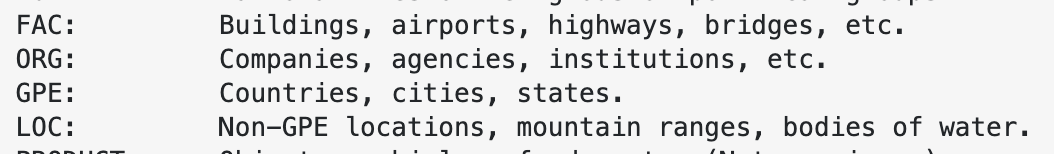

In [ ]:
import spacy
import pymongo
import datetime

if __name__ == "__main__":
    # Connect to MongoDB Client
    client = pymongo.MongoClient("localhost", 27017)
    db = client["boston-hip-hop-interviews"]
    
    # Get collections
    transcript_collection = db["transcript"]

    # load spacy model + pipeline
    nlp = spacy.load("en_core_web_trf")

    # get raw text from mongo
    txts = [(transcript.get("_id"), transcript.get("transcript_raw_text")) for transcript in transcript_collection.find()]
    raw_txts = [txt[1] for txt in txts]
    
    # process all txt files via spacy
    docs = nlp.pipe(raw_txts)
    
    entity_dict_list = []
    # identify and save entities from the text
    for i, doc in enumerate(docs):
        for ent in doc.ents:
            if ent.label_ in ["ORG", "GPE", "LOC", "FAC"]:
                entity_dict = {
                    "entity_text": ent.text,
                    "entity_label": ent.label_,
                    "date_generated": datetime.datetime.now(),
                    "tool_used": "spacy"
                }
                entity_dict_list.append(entity_dict)
        filter_dict = {"_id": txts[i][0]}
        update_dict = {
            "$set": {"named_entities": entity_dict_list}
        }
        print(f"Updating named entities for transcript: {txts[i][0]}")
        result = transcript_collection.update_one(filter_dict, update_dict)

# Data Visualization

The final step of this data pipeline involves visualizing the entity data using an interactive map. Prior to mapping the data, each entity must be geocoded. Geocoding is the process of assigning longitude and latitude coordinates to an object based on a query. In this case, the geocoding API (GeoNames) is provided with the entity's text and attempts to find a location which matches this text. This location search is also supposed to be constrained to the state of Massachusetts / the USA but more often then not GeoNames returns a search result outside of those constraints.

The script below retrieves the extracted entities from the MongoDB and uses the Geocoder library (a Python wrapper for the GeoNames API service) to geocode the entities. If the geocoder is able to find a location that matches the entity, then the locations latitude, longitude, address, and GeoNames ID are all saved to the entity's document.

In [ ]:
import geocoder
import os
import pymongo
# geo_names docs: https://www.geonames.org/export/ws-overview.html

def geocode_entity_dict(entity_dict_list, ignore_list, api_key):
    """Takes a list of entity dictionaries and a list of words to ignore as input. Outputs the list of entities + additional geocoding data."""
    geocoded_entities = []
    for entity_dict in entity_dict_list:
        if entity_dict.get("entity_text").lower() in ignore_list:
            geocoded_entities.append(entity_dict)
            continue
        geocoded_ent = geocoder.geonames(entity_dict.get("entity_text"), key=api_key, adminCod1="MA", country="USA")
        if geocoded_ent:
            entity_dict["address"] = geocoded_ent.address, 
            entity_dict["lat"] = geocoded_ent.lat, 
            entity_dict["lng"] = geocoded_ent.lng, 
            entity_dict["geonames_id"] = geocoded_ent.geonames_id
        geocoded_entities.append(entity_dict)
    return geocoded_entities

if __name__ == "__main__":
    # Connect to MongoDB Client
    client = pymongo.MongoClient("localhost", 27017)
    db = client["boston-hip-hop-interviews"]
    
    # Get collections
    transcript_collection = db["transcript"]

    # get API key and setup ignore list
    geonames_api_key = os.getenv("GEONAMES_API_KEY")
    
    ignore_list = ["boston", "massachusetts", "beantown"]

    for transcript in transcript_collection.find():
        # get the list of entity docs embedded in each transcript
        entity_dict_list = transcript.get("named_entities")
        geocoded_entities = geocode_entity_dict(entity_dict_list, ignore_list, geonames_api_key)

        # parameters to filter the transcript collection so the update command knows which documents to update
        filter_dict = {"_id": transcript.get("_id")}
        update_dict = {
            "$set": {"named_entities": geocoded_entities}
        }
        print(f"Updating named entities for transcript: {transcript.get('_id')} with geocoding info.")
        result = transcript_collection.update_one(filter_dict, update_dict)
        

In [2]:
import folium
import pymongo

# Connect to MongoDB Client
client = pymongo.MongoClient("localhost", 27017)
db = client["boston-hip-hop-interviews"]
    
# Get collections
transcript_collection = db["transcript"]
media_collection = db["media"]

# Generate a map centered on Boston
interactive_map = folium.Map(location=[42.3601, -71.0589])

# iterate over all transcripts
for transcript in transcript_collection.find():
    connected_media = media_collection.find_one({"_id": transcript.get("media_id")})
    video_title = connected_media.get("title")
    
    # iterate over all entities associated with the transcript, plot a marker on the map for each one that has geocoding data associated with it.
    # popup should include both the entity and the media it was mentioned in.
    for entity in transcript.get("named_entities"):
        if entity.get("address"):
            folium.Marker(
                location=[entity.get("lat")[0], entity.get("lng")[0]],
                popup=folium.Popup(f"Entity: {entity.get('entity_text')}\n\n Mentioned in Media: {video_title}"),
                icon=folium.Icon()
            ).add_to(interactive_map)


interactive_map

# Future Work

In this project, I built out and prototyped a data pipeline that:
* Fetched transcribed audio from ~24 episodes of a local Boston Hip hop podcast to create a dataset.
* Used NLP to extract location based entities from the raw text.
* Passed entities to a geocoding API to retrieve geographic coordinates.
* Plotted the data on an interactive map to begin exploring the connections between local Hip hop figures and their surrounding communities.

In terms of next steps, I believe the following tasks would greatly improve the accuracy and efficiency of this pipeline.
* Selecting a different media type (maybe written articles?) or a better video series as a starting dataset to reduce the amount of errors introduced by audio transcription.
* Finding a better speech-to-text conversion algorithm. Either using a pre-built LLM model like OpenAI's Whisper or potentially developing an in-house one to improve transcription accuracy. Alternatively, since the dataset is small, I could also try and manually curate the data to fix inaccuracies.
* Benchmarking different NER algorithms/models and exploring different approaches (Ex. Binary Classification) for extracting location data from text.
* Figuring out a better method for geocoding that would do a better job of restricting the search area to JUST Massachusetts/Boston. Pre-filtering terms that are obviously not related to MA (Ex. names of foreign countries) might also be a good idea.
* Making the map markers more informative, displaying more useful information besides just the entity name and the piece of media it came from.


# Citations

1. Adams, D. (2023, July 17). How Boston quietly triumphed as a seminal Rap City. NPR. https://www.npr.org/2023/07/17/1187519977/hip-hop-50-boston 
2. Adams, D. (n.d.). Boston and hip-hop: An overlooked history. rock the bells. https://rockthebells.com/articles/boston-and-hip-hop-an-overlooked-history/ 
3. Carr, D. (2020, October 14). City scenes: How Boston’s DIY Hip-hop community is fending for itself. NPR. https://www.npr.org/2020/10/14/922245184/city-scenes-how-bostons-diy-hip-hop-community-is-fending-for-itself 
4. Golianopoulos, T. (2015, October 26). How Dave Mays and benzino got back in the game with Hip Hop Weekly. Observer. https://observer.com/2011/09/how-dave-mays-and-benzino-got-back-in-the-game-with-hip-hop-weekly/2/ 
5. Gottlieb, J. (2015, August 21). Boston 101: #16 • “mass appeal” • gang starr. Boston Herald. https://www.bostonherald.com/2015/08/21/boston-101-16-%E2%80%A2-mass-appeal-%E2%80%A2-gang-starr/ 
6. Hip-hop: A culture of vision and voice. The Kennedy Center. (n.d.). https://www.kennedy-center.org/education/resources-for-educators/classroom-resources/media-and-interactives/media/hip-hop/hip-hop-a-culture-of-vision-and-voice/ 
7. Jack Bardsley&nbsp; &nbsp; 5 years ago, Bardsley, J., Jack BardsleyFounded Boston’s Big Four in 2015 See author’s posts, Founded Boston’s Big Four in 2015, &amp; posts, S. author’s. (1965, January 1). Home. Boston’s Big Four. https://www.bostonsbigfour.com/boston-group-stl-gld-is-changing-the-way-hip-hop-is-received-in-boston/ 
8. Mason, A. (2018, February 28). Is Boston hostile to hip-hop?. WBUR News. https://www.wbur.org/news/2018/02/28/boston-hip-hop 
9. Osumare, H. (2014, September 29). Global hip-hop &amp; the african diaspora. Black Cultural Traffic: Crossroads in Global Performance and Popular Culture. https://www.academia.edu/8563515/Global_Hip_Hop_and_The_African_Diaspora 
10. Quan, J. (n.d.). “hip-hop is always there” Jonathan Abrams on his book ‘the come up: An oral history of the rise of hip-hop.’ “Hip-Hop Is Always There” Jonathan Abrams On His Book ‘The Come Up: An Oral History of The Rise of Hip-Hop.’ https://rockthebells.com/articles/the-come-up-an-oral-history-of-the-rise-of-hip-hop/ 
11. Vollmer, A. (2021, August 25). Standing up for developers: YouTube-DL is back. The GitHub Blog. https://github.blog/2020-11-16-standing-up-for-developers-youtube-dl-is-back/ 
12. What is a community of practice?. Community of Practice. (n.d.). https://www.communityofpractice.ca/background/what-is-a-community-of-practice/ 
13. WHDH, 7 News. (2023, July 9). “floor lords” bringing international breakdancing competition to Boston - Boston News, weather, sports: WHDH 7news. Boston News, Weather, Sports | WHDH 7News. https://whdh.com/news/floor-lords-bringing-international-breakdancing-competition-to-boston/ 